## **Advanced Analyitcs and Applications - Data Collection Strategy**

This Jupyter notebook `01_Data_Preparation.ipynb` is the first step in the "Advanced Analytics and Application" team project. Its primary purpose is to handle the initial data collection and preparation tasks. This includes:

* Setting up the Python environment and importing necessary libraries.
* Loading project configurations, including API keys and file paths.
* Fetching taxi trip data from the City of Chicago data portal using a custom API client `src/api/taxi.py`.
* Fetching weather data for Chicago using a custom API client `src/api/weather.py` for a relevant period.
* Storing the raw fetched data for subsequent processing and analysis.

The data collected here will form the basis for descriptive analytics, predictive modeling, and reinforcement learning tasks outlined in the project assignment.

##### **Table of Contents**

0. [Notebook Setup](#Notebook-Set-Up-and-Imports)
1. [Data Collection](#Data-Collection)
1.1. [Taxi Data Collection](#Taxi-Data)
1.2. [Weather Data Collection](#Weather-Data)
3. [References](#References)

##### **Notebook Set Up and Imports**

In [ ]:
%%html
<style>
.dataframe th {
    font-family: "JetBrainsMono Nerd Font";
}
.dataframe td {
    font-family: "JetBrainsMono Nerd Font";
}
</style>

In [1]:
import importlib
import os
import pickle
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import yaml

In [2]:
sys.path.append(str(Path.cwd().parent))
from src.utils.notebook_setup import load_files, setup_notebook

style_manager = setup_notebook()

if str(Path().resolve()).split("/")[-1] == "AAA":
    print("already set repo root")
else:
    notebooks_dir = Path().resolve()
    repo_root = notebooks_dir.parent
    config_dir = repo_root / "config"
    data_dir = repo_root / "data"
    results_dir = data_dir / "results"
    raw_data_dir = data_dir / "raw"
    processed_data_dir = data_dir / "processed"

    with open(config_dir / "config.yaml", "r") as file:
        config = yaml.safe_load(file)
    
    os.chdir(repo_root)

## Data Collection
[Back to Table of Contents](#Table-of-Contents)

### Taxi Data

This section focuses on acquiring taxi trip data from the City of Chicago's Socrata open data portal. This is achieved using a custom-built API client.

**API Client Initialization**:

The ChicagoTaxiAPI class, defined in `src.api.taxi.py`. An instance of the ChicagoTaxiAPI is created. The necessary Socrata App Token for accessing the Chicago Taxi dataset is retrieved from the previously loaded config object (specifically from `config["CHICAGO_TAXI"].get("APP_TOKEN", None)`). Using an `APP_TOKEN` is crucial for avoiding strict rate limits imposed on unauthenticated API requests.

In [3]:
from src.api.taxi import ChicagoTaxiAPI

api = ChicagoTaxiAPI(
    app_token=config["CHICAGO_TAXI"].get("APP_TOKEN", None)
)

df_sample = api.fetch_data(
    select=(
        "trip_id, taxi_id, trip_start_timestamp, trip_end_timestamp, trip_seconds, "
        "trip_miles, pickup_census_tract, dropoff_census_tract, pickup_community_area, "
        "dropoff_community_area, fare, tips, tolls, extras, trip_total, payment_type, "
        "company, pickup_centroid_location, dropoff_centroid_location"
    ),
    where=(
        "pickup_centroid_location IS NOT NULL "
        "AND dropoff_centroid_location IS NOT NULL "
        "AND trip_start_timestamp IS NOT NULL "
        "AND trip_start_timestamp >= '2025-05-01T00:00:00' "
        "AND trip_start_timestamp <= '2025-06-01T00:00:00' "
        "AND trip_seconds > 60 "
        "AND trip_miles > 0.1 "
        "AND fare IS NOT NULL "
        "AND trip_total IS NOT NULL"
    ),
    order="trip_start_timestamp DESC",
    limit=1000000,
)


api.close()

In [ ]:
df_sample = df_sample.dropna(subset=["pickup_community_area", "dropoff_community_area"])
df_sample
df_sample.info()
df_sample.head()
df_sample.describe()


In [5]:
import folium
import geopandas as gpd
from shapely.geometry import LineString
from IPython.display import display
#########################
# considering that using the entire dataset is Computationally expensive, Memory-heavy, Unusable in Folium and Visually cluttered, a subset will be used instead.
#########################
# Rebuild geometry
df_sample["geometry"] = df_sample.apply(
    lambda row: LineString([
        row["pickup_centroid_location"]["coordinates"],
        row["dropoff_centroid_location"]["coordinates"]
    ]) if row["pickup_centroid_location"] and row["dropoff_centroid_location"] else None,
    axis=1
)
# gdf = gpd.GeoDataFrame(df_sample, geometry="geometry", crs="EPSG:4326").dropna(subset=["geometry"])

df_subset = df_sample.sample(n=500, random_state=42)

# Rebuild geometry only for subset
df_subset["geometry"] = df_subset.apply(
    lambda row: LineString([
        row["pickup_centroid_location"]["coordinates"],
        row["dropoff_centroid_location"]["coordinates"]
    ]) if row["pickup_centroid_location"] and row["dropoff_centroid_location"] else None,
    axis=1
)

gdf = gpd.GeoDataFrame(df_subset, geometry="geometry", crs="EPSG:4326").dropna(subset=["geometry"])

# Center map on chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add trip lines
for line in gdf["geometry"]:
    folium.PolyLine(
        locations=[(lat, lon) for lon, lat in line.coords],
        color="blue", weight=2, opacity=0.5
    ).add_to(m)

# Add pickup and dropoff markers
for _, row in gdf.iterrows():
    pickup_coords = row["pickup_centroid_location"]["coordinates"]
    dropoff_coords = row["dropoff_centroid_location"]["coordinates"]
    
    folium.CircleMarker(
        location=(pickup_coords[1], pickup_coords[0]),  # lat, lon
        radius=4,
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.7,
        popup=f"Pickup: {row['trip_start_timestamp']}"
    ).add_to(m)
    
    folium.CircleMarker(
        location=(dropoff_coords[1], dropoff_coords[0]),  # lat, lon
        radius=4,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7,
        popup=f"Dropoff: {row['trip_end_timestamp']}"
    ).add_to(m)

# Show map in notebook
display(m)

In [6]:
from datetime import datetime, timedelta
from pathlib import Path

# Define the date range
start_date = datetime(2025, 5, 1)
end_date = datetime(2025, 6, 1)
delta = timedelta(days=1)

current = start_date

# Ensure base raw data directory exists
raw_data_dir.mkdir(parents=True, exist_ok=True)

# Loop over each day
while current < end_date:
    next_day = current + delta
    date_str = current.strftime('%Y-%m-%d')
    next_str = next_day.strftime('%Y-%m-%d')

    # Create output directory for the current day
    output_path = raw_data_dir / date_str
    output_path.mkdir(parents=True, exist_ok=True)

    print(f"📦 Fetching data for {date_str}...")

    try:
        df_batch = api.fetch_batch_data(
            select=(
                "trip_id, taxi_id, trip_start_timestamp, trip_end_timestamp, trip_seconds, "
                "trip_miles, pickup_census_tract, dropoff_census_tract, pickup_community_area, "
                "dropoff_community_area, fare, tips, tolls, extras, trip_total, payment_type, "
                "company, pickup_centroid_location, dropoff_centroid_location"
            ),
            where=(
                f"pickup_centroid_location IS NOT NULL AND "
                f"dropoff_centroid_location IS NOT NULL AND "
                f"trip_start_timestamp >= '{date_str}T00:00:00' AND "
                f"trip_start_timestamp < '{next_str}T00:00:00' AND "
                f"trip_start_timestamp <= trip_end_timestamp"
            ),
            output_dir=output_path,
            records_to_fetch=100000,
            batch_size=50000
        )

        print(f"✅ Finished fetching {len(df_batch)} records for {date_str}.")

    except Exception as e:
        print(f"❌ Failed to fetch data for {date_str}: {e}")

    current = next_day

# Close the API connection at the end
api.close()


📦 Fetching data for 2025-05-01...


Fetching all data:  21%|██        | 20624/100000 [00:05<00:19, 4083.11rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 20,624 records.
✅ Finished fetching 20624 records for 2025-05-01.
📦 Fetching data for 2025-05-02...


Fetching all data:  18%|█▊        | 17971/100000 [00:09<00:45, 1797.76rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 17,971 records.
✅ Finished fetching 17971 records for 2025-05-02.
📦 Fetching data for 2025-05-03...


Fetching all data:  14%|█▍        | 13827/100000 [00:04<00:26, 3307.18rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 13,827 records.
✅ Finished fetching 13827 records for 2025-05-03.
📦 Fetching data for 2025-05-04...


Fetching all data:  15%|█▌        | 15240/100000 [00:01<00:10, 8295.96rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 15,240 records.
✅ Finished fetching 15240 records for 2025-05-04.
📦 Fetching data for 2025-05-05...


Fetching all data:  21%|██        | 20776/100000 [00:01<00:06, 13099.99rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 20,776 records.
✅ Finished fetching 20776 records for 2025-05-05.
📦 Fetching data for 2025-05-06...


Fetching all data:  22%|██▏       | 22445/100000 [00:01<00:05, 13225.17rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 22,445 records.
✅ Finished fetching 22445 records for 2025-05-06.
📦 Fetching data for 2025-05-07...


Fetching all data:  22%|██▏       | 21961/100000 [00:01<00:05, 15365.67rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 21,961 records.
✅ Finished fetching 21961 records for 2025-05-07.
📦 Fetching data for 2025-05-08...


Fetching all data:  21%|██▏       | 21271/100000 [00:02<00:08, 9342.61rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 21,271 records.
✅ Finished fetching 21271 records for 2025-05-08.
📦 Fetching data for 2025-05-09...


Fetching all data:  19%|█▊        | 18695/100000 [00:02<00:10, 7562.17rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 18,695 records.
✅ Finished fetching 18695 records for 2025-05-09.
📦 Fetching data for 2025-05-10...


Fetching all data:  14%|█▍        | 14389/100000 [00:01<00:07, 11271.75rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 14,389 records.
✅ Finished fetching 14389 records for 2025-05-10.
📦 Fetching data for 2025-05-11...


Fetching all data:  13%|█▎        | 13015/100000 [00:02<00:16, 5225.65rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 13,015 records.
✅ Finished fetching 13015 records for 2025-05-11.
📦 Fetching data for 2025-05-12...


Fetching all data:  18%|█▊        | 17719/100000 [00:01<00:06, 13267.22rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 17,719 records.
✅ Finished fetching 17719 records for 2025-05-12.
📦 Fetching data for 2025-05-13...


Fetching all data:  19%|█▉        | 19293/100000 [00:01<00:05, 14499.98rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 19,293 records.
✅ Finished fetching 19293 records for 2025-05-13.
📦 Fetching data for 2025-05-14...


Fetching all data:  21%|██        | 21031/100000 [00:01<00:05, 14649.92rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 21,031 records.
✅ Finished fetching 21031 records for 2025-05-14.
📦 Fetching data for 2025-05-15...


Fetching all data:  23%|██▎       | 23025/100000 [00:02<00:07, 10896.96rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 23,025 records.
✅ Finished fetching 23025 records for 2025-05-15.
📦 Fetching data for 2025-05-16...


Fetching all data:  25%|██▍       | 24802/100000 [00:02<00:07, 9765.32rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 24,802 records.
✅ Finished fetching 24802 records for 2025-05-16.
📦 Fetching data for 2025-05-17...


Fetching all data:  19%|█▉        | 19474/100000 [00:01<00:05, 14408.68rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 19,474 records.
✅ Finished fetching 19474 records for 2025-05-17.
📦 Fetching data for 2025-05-18...


Fetching all data:  19%|█▉        | 18832/100000 [00:01<00:05, 14395.23rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 18,832 records.
✅ Finished fetching 18832 records for 2025-05-18.
📦 Fetching data for 2025-05-19...


Fetching all data:  23%|██▎       | 23030/100000 [00:01<00:04, 16340.30rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 23,030 records.
✅ Finished fetching 23030 records for 2025-05-19.
📦 Fetching data for 2025-05-20...


Fetching all data:  23%|██▎       | 22580/100000 [00:01<00:06, 12637.42rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 22,580 records.
✅ Finished fetching 22580 records for 2025-05-20.
📦 Fetching data for 2025-05-21...


Fetching all data:  22%|██▏       | 22149/100000 [00:01<00:05, 13027.75rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 22,149 records.
✅ Finished fetching 22149 records for 2025-05-21.
📦 Fetching data for 2025-05-22...


Fetching all data:  22%|██▏       | 21529/100000 [00:03<00:11, 6841.83rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 21,529 records.
✅ Finished fetching 21529 records for 2025-05-22.
📦 Fetching data for 2025-05-23...


Fetching all data:  18%|█▊        | 18490/100000 [00:01<00:05, 13928.17rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 18,490 records.
✅ Finished fetching 18490 records for 2025-05-23.
📦 Fetching data for 2025-05-24...


Fetching all data:  14%|█▍        | 13945/100000 [00:02<00:17, 5045.49rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 13,945 records.
✅ Finished fetching 13945 records for 2025-05-24.
📦 Fetching data for 2025-05-25...


Fetching all data:  13%|█▎        | 12908/100000 [00:01<00:07, 11603.55rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 12,908 records.
✅ Finished fetching 12908 records for 2025-05-25.
📦 Fetching data for 2025-05-26...


Fetching all data:  12%|█▏        | 12245/100000 [00:00<00:07, 12501.16rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 12,245 records.
✅ Finished fetching 12245 records for 2025-05-26.
📦 Fetching data for 2025-05-27...


Fetching all data:  17%|█▋        | 16770/100000 [00:01<00:06, 13011.41rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 16,770 records.
✅ Finished fetching 16770 records for 2025-05-27.
📦 Fetching data for 2025-05-28...


Fetching all data:  20%|█▉        | 19965/100000 [00:01<00:05, 15084.99rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 19,965 records.
✅ Finished fetching 19965 records for 2025-05-28.
📦 Fetching data for 2025-05-29...


Fetching all data:  22%|██▏       | 22104/100000 [00:01<00:04, 15830.01rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 22,104 records.
✅ Finished fetching 22104 records for 2025-05-29.
📦 Fetching data for 2025-05-30...


Fetching all data:  24%|██▍       | 24181/100000 [00:01<00:05, 14077.14rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 24,181 records.
✅ Finished fetching 24181 records for 2025-05-30.
📦 Fetching data for 2025-05-31...


Fetching all data:  20%|█▉        | 19530/100000 [00:01<00:05, 14269.93rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 19,530 records.
✅ Finished fetching 19530 records for 2025-05-31.


In [7]:
import pandas as pd
from pathlib import Path

raw_files = list((raw_data_dir).rglob("*.parquet"))  # or *.csv if you switched formats

df_all = pd.concat([pd.read_parquet(f) for f in raw_files], ignore_index=True)
# print(df_all.shape)


In [8]:
from src.api.weather import ChicagoWeatherAPI
from datetime import date
import pandas as pd

weather_api = ChicagoWeatherAPI()

from src.api.weather import ChicagoWeatherAPI
import pandas as pd

# start_date = df_all['trip_start_timestamp'].min().date()
# end_date = df_all['trip_start_timestamp'].max().date()

print(f"Fetching weather data from {start_date} to {end_date}...")

weather_api = ChicagoWeatherAPI()

historical_df = weather_api.get_historical_weather(
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    hourly_vars=["temperature_2m", "precipitation", "weather_code", "wind_speed_10m"],
    daily_vars=["temperature_2m_max", "temperature_2m_min", "precipitation_sum"]
)

forecast_df = weather_api.get_forecast_weather(
    days=3,
    hourly_vars=["temperature_2m", "apparent_temperature", "precipitation_probability"],
    daily_vars=["sunrise", "sunset", "uv_index_max"]
)

weather_api.close()

historical_df = historical_df.reset_index()
historical_df.rename(columns={'time': 'datetime'}, inplace=True)
historical_df['datetime'] = pd.to_datetime(historical_df['datetime'])
historical_df['hour'] = historical_df['datetime'].dt.hour
historical_df['date'] = historical_df['datetime'].dt.date

forecast_df = forecast_df.reset_index()
forecast_df.rename(columns={'time': 'datetime'}, inplace=True)
forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])
forecast_df['hour'] = forecast_df['datetime'].dt.hour
forecast_df['date'] = forecast_df['datetime'].dt.date



Fetching weather data from 2025-05-01 00:00:00 to 2025-06-01 00:00:00...


In [ ]:
historical_df

In [ ]:
forecast_df

#### Taxi Dataset EDA

In [ ]:
df_sample.info()
df_sample.describe(include='all')
df_sample.isna().sum()

# Example distribution
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

sns.histplot(df_sample["trip_seconds"], bins=50)
plt.xlim(0, 7200)  # Limit to 2 hours
plt.title("Trip Duration Distribution (Capped at 1 Hour)")
plt.xlabel("trip_seconds")
plt.ylabel("Count")
plt.show()

#### Temporal Discretization

In [9]:
df_sample['trip_start_timestamp'] = pd.to_datetime(df_sample['trip_start_timestamp'])
df_sample['hour'] = df_sample['trip_start_timestamp'].dt.hour
df_sample['weekday'] = df_sample['trip_start_timestamp'].dt.dayofweek
df_sample['is_weekend'] = df_sample['weekday'] >= 5
df_sample['time_bucket'] = df_sample['hour'] // 4  # 6 slots per day


bucket_labels = [
    "Late Night",    # 0: 00–04
    "Morning Rush",  # 1: 04–08
    "Mid-Morning",   # 2: 08–12
    "Afternoon",     # 3: 12–16
    "Evening Rush",  # 4: 16–20
    "Night"          # 5: 20–24
]
df_sample['time_label'] = df_sample['time_bucket'].map(dict(enumerate(bucket_labels)))


#### Spatial Discretization Using H3

In [10]:
import h3

def point_to_h3(coord, res=8):
    lat, lon = coord[1], coord[0]  # lat/lon order
    return h3.latlng_to_cell(lat, lon, res)

df_sample['h3_pickup'] = df_sample['pickup_centroid_location'].apply(lambda x: point_to_h3(x['coordinates']))
df_sample['h3_dropoff'] = df_sample['dropoff_centroid_location'].apply(lambda x: point_to_h3(x['coordinates']))


In [11]:
df_sample["geometry"] = df_sample.apply(
    lambda row: LineString([
        row["pickup_centroid_location"]["coordinates"],
        row["dropoff_centroid_location"]["coordinates"]
    ]) if row["pickup_centroid_location"] and row["dropoff_centroid_location"] else None,
    axis=1
)

In [12]:
df_sample['geometry_wkt'] = df_sample['geometry'].apply(lambda g: g.wkt if g else None)
df_sample.drop(columns=['geometry'], inplace=True)
df_sample.to_parquet(processed_data_dir / "cleaned_trips.parquet", index=False)
#to reconstruct the geometry
# from shapely import wkt
# df_sample['geometry'] = df_sample['geometry_wkt'].apply(wkt.loads)


In [13]:

df_sample['trip_start_timestamp'] = pd.to_datetime(df_sample['trip_start_timestamp'])
df_sample['trip_hour'] = df_sample['trip_start_timestamp'].dt.floor('h')


historical_df.columns = [col.lower().strip() for col in historical_df.columns]

if 'time' in historical_df.columns:
    historical_df.rename(columns={'time': 'datetime'}, inplace=True)

historical_df['datetime'] = pd.to_datetime(historical_df['datetime'])
historical_df['weather_hour'] = historical_df['datetime'].dt.floor('h')

df_merged = pd.merge(
    df_sample,
    historical_df,
    left_on='trip_hour',
    right_on='weather_hour',
    how='left'
)

df_sample.to_parquet(processed_data_dir / "cleaned_trips.parquet", index=False)
historical_df.to_parquet(processed_data_dir / "cleaned_weather.parquet", index=False)
df_merged.to_parquet(processed_data_dir / "merged_trips_weather.parquet", index=False)

print("✅ Saved: cleaned_trips, cleaned_weather, merged_trips_weather")

✅ Saved: cleaned_trips, cleaned_weather, merged_trips_weather


In [14]:
import pandas as pd

# Load the parquet file
df = pd.read_parquet("data/processed/merged_trips_weather.parquet")

# Export to CSV
df.to_csv("data/processed/merged_trips_weather.csv", index=False)


In [ ]:
df

## Descriptive Analytics

#### Temporal Demand Patterns (Trips per Hour vs. Day of Week)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Trips per hour
sns.histplot(df['hour_x'], bins=24)
plt.title("Hourly Taxi Demand")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.show()

# Trips by day of week
sns.countplot(x='weekday', data=df)
plt.title("Trips by Weekday (0=Mon)")
plt.show()


#### Spatial Demand (Trip Count by Pickup H3)

In [15]:
trip_by_h3 = df.groupby('h3_pickup').size().reset_index(name='trip_count')
trip_by_h3.sort_values('trip_count', ascending=False).head(10)


,h3_pickup,trip_count
62,882664c1edfffff,59359
226,88275934edfffff,53463
51,882664c1a9fffff,53289
225,8827593433fffff,40729
57,882664c1e3fffff,37920
53,882664c1adfffff,29265
56,882664c1e1fffff,24869
84,882664ca91fffff,20979
44,882664c163fffff,18832
61,882664c1ebfffff,14494


findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not found.
findfont: Font family 'JetBrainsMono Nerd Font' not foun

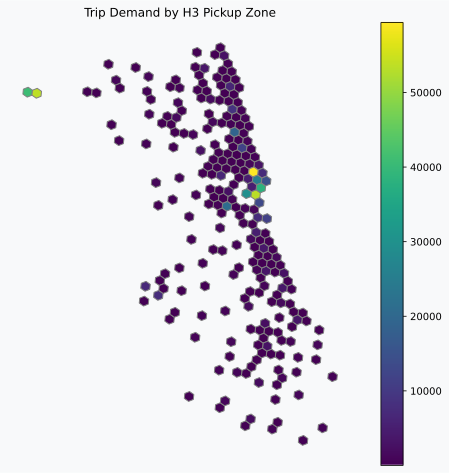

In [16]:
import h3
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Group by H3 pickup
trip_by_h3 = df.groupby('h3_pickup').size().reset_index(name='trip_count')

# ✅ Convert boundary and reformat to (lon, lat)
def h3_to_polygon(h3_index):
    boundary = h3.cell_to_boundary(h3_index)  # Returns list of (lat, lon)
    boundary_lonlat = [(lon, lat) for lat, lon in boundary]
    return Polygon(boundary_lonlat)

trip_by_h3['geometry'] = trip_by_h3['h3_pickup'].apply(h3_to_polygon)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(trip_by_h3, geometry='geometry', crs='EPSG:4326')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='trip_count', cmap='viridis', edgecolor='grey', legend=True, ax=ax)
ax.set_title("Trip Demand by H3 Pickup Zone")
ax.set_axis_off()
plt.show()


#### Trip Length - Time - Location

In [ ]:
sns.histplot(df['trip_seconds'] / 60, bins=500)
plt.xlim(0, 100)  # Show only first 60 minutes
plt.title("Trip Duration (Minutes, Zoomed In)")
plt.xlabel("Minutes")
plt.ylabel("Trip Count")
plt.show()

In [ ]:
df.groupby('h3_pickup')['trip_miles'].mean().sort_values(ascending=False).head(10)


In [ ]:
# spatial-temporal demand matrix

df['trip_hour'] = pd.to_datetime(df['trip_start_timestamp']).dt.floor('h')
demand_matrix = df.groupby(['trip_hour', 'h3_pickup']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))  # Optional: wider plot
sns.heatmap(demand_matrix.T, cmap="YlGnBu", cbar_kws={"label": "Trip Count"})
plt.xlabel("Hour")
plt.ylabel("H3 Pickup Zone")
plt.title("Taxi Demand by Time and H3 Zone")
plt.tight_layout()
plt.show()



In [ ]:
# Only Top N Busy H3 Zones

# top 20 H3 zones by total trip count
top_h3 = df['h3_pickup'].value_counts().head(20).index

# Filter the matrix
filtered_df = df[df['h3_pickup'].isin(top_h3)]
filtered_matrix = (
    filtered_df
    .groupby(['trip_hour', 'h3_pickup'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(14, 8))
sns.heatmap(filtered_matrix.T, cmap="YlGnBu", cbar_kws={"label": "Trip Count"})
plt.title("Taxi Demand by Time and Top 20 H3 Zones")
plt.xlabel("Hour")
plt.ylabel("H3 Pickup Zone")
plt.tight_layout()
plt.show()


In [ ]:
# Aggregate Temporally (e.g., 4-hour bins or by day)
# Create 4-hour bins
df['trip_4h'] = pd.to_datetime(df['trip_start_timestamp']).dt.floor('4H')

# Then redo the matrix for top zones
filtered_df = df[df['h3_pickup'].isin(top_h3)]
matrix_4h = filtered_df.groupby(['trip_4h', 'h3_pickup']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(matrix_4h.T, cmap="YlGnBu", cbar_kws={"label": "Trip Count"})
plt.title("Taxi Demand (4-Hour Bins) by Top H3 Zones")
plt.xlabel("4-Hour Window")
plt.ylabel("H3 Pickup Zone")
plt.tight_layout()
plt.show()



#### Pricing Behavior

In [ ]:
# Average Fare by Hour or Time Bucket
df.groupby('hour_x')['trip_total'].mean().plot()
plt.title("Average Fare by Hour")
plt.ylabel("Fare ($)")
plt.show()



In [ ]:
#Tip Rates by Company
df['tip_rate'] = df['tips'] / df['fare']
df.groupby('company')['tip_rate'].mean().sort_values(ascending=False).head(10)


#### Idle Time Between Trips

In [ ]:
df_sorted = df.sort_values(by=['taxi_id', 'trip_start_timestamp'])
df_sorted['prev_end'] = df_sorted.groupby('taxi_id')['trip_end_timestamp'].shift(1)
df_sorted['idle_time'] = (
    pd.to_datetime(df_sorted['trip_start_timestamp']) -
    pd.to_datetime(df_sorted['prev_end'])
).dt.total_seconds() / 60  # in minutes

# Average idle time by hour
df_sorted.groupby('hour_x')['idle_time'].mean().plot()
plt.title("Average Idle Time by Hour")
plt.ylabel("Idle Time (min)")
plt.show()


#### Weather Impact Analysis

In [ ]:
df['is_rainy'] = df['precipitation'] > 0

sns.boxplot(x='is_rainy', y='trip_total', data=df)
plt.title("Fare Total vs. Rain (Precipitation > 0)")
plt.xlabel("Rainy")
plt.ylabel("Trip Total ($)")
plt.show()



In [ ]:
sns.boxplot(x='hour_x', y='trip_total', hue='is_rainy', data=df)
plt.title("Hourly Fare Total: Rain vs No Rain")
plt.legend(title='Rainy')
plt.show()


In [ ]:
sns.countplot(x='is_rainy', data=df)
plt.title("Trip Count: Rain vs No Rain")
plt.xlabel("Rainy")
plt.ylabel("Number of Trips")
plt.show()


In [ ]:
sns.boxplot(x='is_rainy', y=df['trip_seconds'] / 60, data=df)
plt.title("Trip Duration (minutes) vs. Rain")
plt.ylabel("Trip Duration (min)")
plt.xlabel("Rainy")
plt.show()


#### 	GMM Spatial Clustering of Pickups

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Extracting pickup lat/lon
df['pickup_lon'] = df['pickup_centroid_location'].apply(lambda x: x['coordinates'][0])
df['pickup_lat'] = df['pickup_centroid_location'].apply(lambda x: x['coordinates'][1])
coords = df[['pickup_lat', 'pickup_lon']].dropna().values

n_components = 6  #number of clusters

gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(coords)

# Predict cluster for each pickup
df['gmm_cluster'] = gmm.predict(coords)

# Visualizing clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for i in range(n_components):
    cluster_data = df[df['gmm_cluster'] == i]
    plt.scatter(cluster_data['pickup_lon'], cluster_data['pickup_lat'], 
                s=10, label=f"Cluster {i}", alpha=0.5)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GMM Spatial Clusters of Pickup Demand")
plt.grid(True)
plt.show()



In [ ]:
# Gaussian ellipse plotting
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    ell = Ellipse(position, width, height, angle, **kwargs)
    ax.add_patch(ell)

# Plot with ellipses
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(coords[:, 1], coords[:, 0], s=2, alpha=0.2)

for pos, cov in zip(gmm.means_, gmm.covariances_):
    draw_ellipse(pos[::-1], cov[:2, :2], ax, edgecolor='red', facecolor='none', lw=2)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("GMM Ellipses over Pickup Hotspots")
plt.grid(True)
plt.show()


In [ ]:
# Kernel Density Estimation (smooth density map)
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=df['pickup_lon'], y=df['pickup_lat'], 
    cmap="Reds", fill=True, bw_adjust=0.1, levels=100, thresh=0.01
)
plt.title("Pickup Location Density (KDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Predictive Analytics
### SVM

In [17]:
# Load & Prepare Aggregated Features

df = pd.read_parquet("data/processed/merged_trips_weather.parquet")

# Bin to 1-hour resolution (can later change to 2h/6h/24h)
df['time_bin'] = pd.to_datetime(df['trip_start_timestamp']).dt.floor('1h')

# Aggregate demand: trips per hex + hour
agg = df.groupby(['h3_pickup', 'time_bin']).agg(
    trip_count=('trip_id', 'count'),
    temp=('temperature_2m', 'mean'),
    precip=('precipitation', 'mean'),
    wind=('wind_speed_10m', 'mean')
).reset_index()

agg.dropna(inplace=True) 


# Encode & Split Features

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode H3 zones (categorical → numeric)
le = LabelEncoder()
agg['h3_encoded'] = le.fit_transform(agg['h3_pickup'])

# Convert time to numeric (hour of day and day of week)
agg['hour'] = agg['time_bin'].dt.hour
agg['weekday'] = agg['time_bin'].dt.weekday

# Define features & target
features = ['h3_encoded', 'hour', 'weekday', 'temp', 'precip', 'wind']
target = 'trip_count'

X = agg[features]
y = agg[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


#### Train Baseline SVM

In [18]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Linear SVM first
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Linear SVM MSE: {mse:.2f}")


Linear SVM MSE: 1192.41


### SVM with Kernel + GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

svm = SVR()
grid = GridSearchCV(svm, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred)
print(f"Best SVM (GridSearch) MSE: {mse_best:.2f}")


#### Train Feedforward Neural Network (FNN)

In [21]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(1e-3), loss='mse')
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Predict & Evaluate
y_pred_nn = model.predict(X_test_scaled).flatten()
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network MSE: {mse_nn:.2f}")


c:\Users\suuser\AppData\Local\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 687.9760 - val_loss: 104.5237
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 540.9848 - val_loss: 36.3139
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 491.0250 - val_loss: 21.1003
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 479.6377 - val_loss: 21.3576
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 500.3567 - val_loss: 11.8227
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 470.7401 - val_loss: 20.0794
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 483.0625 - val_loss: 17.3638
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 453.5625 - val_loss: 17.5844
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 495.7854 - val_loss: 12.9724
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 464.4170 - val_loss: 16.6522
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 457.1067 - val_loss: 10.5

### Varying Resolution Experiments

In [23]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_parquet("data/processed/merged_trips_weather.parquet")

def run_fnn_experiment(df, time_res='1h', spatial_unit='h3_pickup'):
    df = df.copy()
    df['time_bin'] = pd.to_datetime(df['trip_start_timestamp']).dt.floor(time_res)
    
    group_cols = [spatial_unit, 'time_bin']
    agg = df.groupby(group_cols).agg(
        trip_count=('trip_id', 'count'),
        temp=('temperature_2m', 'mean'),
        precip=('precipitation', 'mean'),
        wind=('wind_speed_10m', 'mean')
    ).reset_index()

    agg.dropna(inplace=True)
    le = LabelEncoder()
    agg['spatial_encoded'] = le.fit_transform(agg[spatial_unit])
    agg['hour'] = agg['time_bin'].dt.hour
    agg['weekday'] = agg['time_bin'].dt.weekday

    X = agg[['spatial_encoded', 'hour', 'weekday', 'temp', 'precip', 'wind']]
    y = agg['trip_count']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(1e-3), loss='mse')
    model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)

    y_pred = model.predict(X_test_scaled).flatten()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return {
        'Time Resolution': time_res,
        'Spatial Unit': spatial_unit,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2)
    }

# Run experiments
resolutions = ['1h', '2h', '4h']
spatial_units = ['h3_pickup', 'pickup_census_tract']
results = []

for res in resolutions:
    for spatial in spatial_units:
        results.append(run_fnn_experiment(df, time_res=res, spatial_unit=spatial))

# Results
results_df = pd.DataFrame(results)
print(results_df)


c:\Users\suuser\AppData\Local\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Users\suuser\AppData\Local\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\suuser\AppData\Local\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Users\suuser\AppData\Local\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\suuser\AppData\Local\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\suuser\AppData\Local\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Time Resolution         Spatial Unit    MAE    RMSE
0              1h            h3_pickup  13.67   33.92
1              1h  pickup_census_tract  36.06   58.43
2              2h            h3_pickup  22.50   59.79
3              2h  pickup_census_tract  56.15  101.33
4              4h            h3_pickup  48.39  115.24
5              4h  pickup_census_tract  80.09  169.25
